<a href="https://colab.research.google.com/github/Abdus56/First-Repository/blob/main/SMP_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

📂 Please choose a CSV file from your local machine…


Saving large_business_data.csv to large_business_data.csv
✅ Loaded 'large_business_data.csv' with shape (50000, 12)


,GP,Revenue,COGS,MarketingSpend,Headcount,CustomerSatisfaction,InventoryTurnover,DebtRatio,CreditRisk_High,CreditRisk_Medium,CreditRisk_Low,ReturnsPct
0,47543.51,128154.21,83337.18,13852.63,246,79.58,9.45,0.41,0,0,1,0.048948
1,55747.32,121212.66,65856.23,10611.28,184,69.54,3.44,0.71,0,1,0,0.074703
2,43766.74,80446.40,36369.99,9785.48,338,78.09,9.82,0.53,0,1,0,0.040086
3,43331.24,119416.46,80412.98,9227.37,380,77.43,6.81,0.56,0,1,0,0.058117
4,73589.37,172289.30,97606.11,9043.03,343,72.75,8.03,0.47,0,1,0,0.098504



Model type ('simple', 'multiple', 'poly'): multiple

Columns (choose by NUMBER):
   1: GP
   2: Revenue
   3: COGS
   4: MarketingSpend
   5: Headcount
   6: CustomerSatisfaction
   7: InventoryTurnover
   8: DebtRatio
   9: CreditRisk_High
  10: CreditRisk_Medium
  11: CreditRisk_Low
  12: ReturnsPct

Enter the column NUMBER for the dependent (target) variable: 1
Select independent variables: 'all', a range '2-6', or a list '1,3,4': all

Target: GP
Predictors: ['Revenue', 'COGS', 'MarketingSpend', 'Headcount', 'CustomerSatisfaction', 'InventoryTurnover', 'DebtRatio', 'CreditRisk_High', 'CreditRisk_Medium', 'CreditRisk_Low', 'ReturnsPct']

Full model fitted for σ² estimate. R²(full) = 0.9743

Top 5 models by lowest Mallows' Cₚ (tie-break not applied):


,k,Predictors,R2,Cp
0,3,"[Revenue, COGS, DebtRatio]",0.974336,-0.663255
1,2,"[Revenue, COGS]",0.974334,0.261905
2,4,"[Revenue, COGS, InventoryTurnover, DebtRatio]",0.974336,0.401571
3,4,"[Revenue, COGS, MarketingSpend, DebtRatio]",0.974336,0.500365
4,4,"[Revenue, COGS, DebtRatio, CreditRisk_Low]",0.974336,1.082224


Bottom 5 models by highest Mallows' Cₚ:


,k,Predictors,R2,Cp
0,4,"[CreditRisk_High, CreditRisk_Medium, CreditRis...",-0.000108,1.898136e+06
1,1,[InventoryTurnover],0.000006,1.897908e+06
2,1,[MarketingSpend],0.000013,1.897894e+06
3,1,[CreditRisk_Low],0.000013,1.897893e+06
4,1,[CustomerSatisfaction],0.000014,1.897892e+06


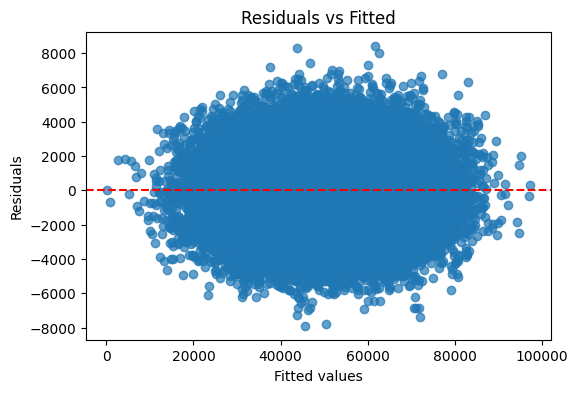

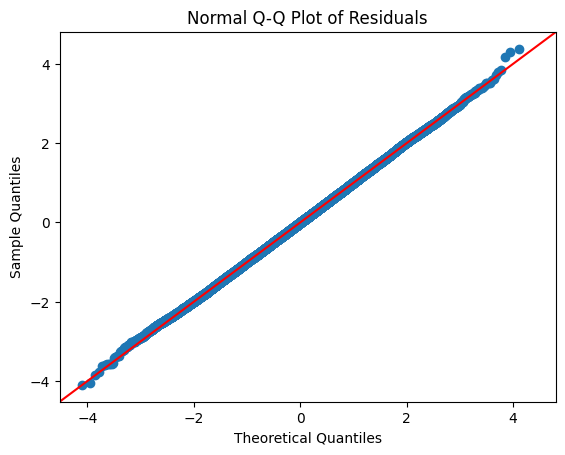

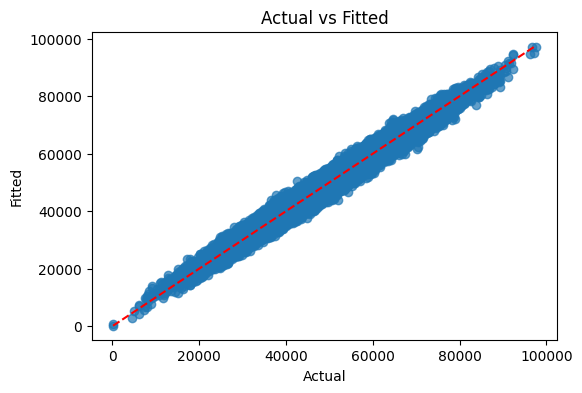

In [3]:


import io
import itertools
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from IPython.display import display

# ---------- Step 0: Upload CSV ----------
try:
    from google.colab import files  # only in Colab
    print("📂 Please choose a CSV file from your local machine…")
    uploaded = files.upload()
    filename = next(iter(uploaded))
    df = pd.read_csv(io.BytesIO(uploaded[filename]))
    print(f"✅ Loaded '{filename}' with shape {df.shape}")
except ModuleNotFoundError:
    path = input("Path to CSV: ").strip()
    df = pd.read_csv(path)
    print(f"✅ Loaded '{path}' with shape {df.shape}")

display(df.head())

# ---------- Helpers ----------
def show_columns(_df: pd.DataFrame):
    print("\nColumns (choose by NUMBER):")
    for i, c in enumerate(_df.columns, start=1):
        print(f"  {i:>2}: {c}")

def parse_selector(sel: str, ncols: int):
    """
    Supports:
      - 'all'         → all columns (caller will remove target later)
      - '1,3,7'       → comma-separated list
      - '2-5'         → inclusive range
      - mixtures like  '1,4-6,9'
    Returns a sorted list of unique 1-based indices.
    """
    sel = sel.strip().lower()
    if sel == "all":
        return list(range(1, ncols+1))
    out = set()
    for part in sel.split(","):
        part = part.strip()
        if "-" in part:
            a, b = part.split("-")
            a, b = int(a), int(b)
            out.update(range(min(a,b), max(a,b)+1))
        else:
            out.add(int(part))
    if any(i < 1 or i > ncols for i in out):
        raise ValueError("One or more selected indices are out of range.")
    return sorted(out)

# Quote non-identifier names for Patsy/statsmodels formulas
def qname(col: str) -> str:
    return col if col.isidentifier() else f'Q("{col}")'

def fit_formula(formula: str, data: pd.DataFrame):
    return smf.ols(formula, data=data).fit()

def mallows_cp(SSE, sigma2_hat, n, p):
    # p includes intercept
    return SSE / sigma2_hat - (n - 2*p)

# ---------- Step 1: Choose MODEL TYPE first ----------
model_type = input("\nModel type ('simple', 'multiple', 'poly'): ").strip().lower()
if model_type not in {"simple", "multiple", "poly"}:
    raise ValueError("Model type must be one of: simple, multiple, poly")

# ---------- Step 2: Variable selection AFTER model choice ----------
show_columns(df)
target_idx = int(input("\nEnter the column NUMBER for the dependent (target) variable: ").strip())
if not (1 <= target_idx <= df.shape[1]):
    raise ValueError("Target index out of range.")
target_col = df.columns[target_idx-1]

if model_type == "simple":
    x_idx = int(input("Enter the column NUMBER for the single independent variable: ").strip())
    if not (1 <= x_idx <= df.shape[1]):
        raise ValueError("Predictor index out of range.")
    if x_idx == target_idx:
        raise ValueError("Predictor must be different from the target.")
    predictor_cols = [df.columns[x_idx-1]]

elif model_type == "poly":
    x_idx = int(input("Enter the column NUMBER for the single independent variable (to polynomialise): ").strip())
    if not (1 <= x_idx <= df.shape[1]):
        raise ValueError("Predictor index out of range.")
    if x_idx == target_idx:
        raise ValueError("Predictor must be different from the target.")
    predictor_cols = [df.columns[x_idx-1]]

else:  # multiple
    pred_sel = input("Select independent variables: 'all', a range '2-6', or a list '1,3,4': ").strip()
    pred_indices = parse_selector(pred_sel, df.shape[1])
    pred_indices = [i for i in pred_indices if i != target_idx]  # remove target if included
    if len(pred_indices) == 0:
        raise ValueError("No predictor columns selected.")
    predictor_cols = [df.columns[i-1] for i in pred_indices]

print(f"\nTarget: {target_col}")
print(f"Predictors: {predictor_cols}")

# Prepare modelling frame without missing values in used columns
dfm = df.dropna(subset=[target_col] + predictor_cols).copy()

# Quoted names for formulas
tq = qname(target_col)
pqs = [qname(c) for c in predictor_cols]

# ---------- Step 3: Model fitting paths ----------
best_res = None  # will be set per path

if model_type == "simple":
    # Simple Linear Regression: Y ~ X
    formula = f"{tq} ~ {pqs[0]}"
    res = fit_formula(formula, dfm)
    print(f"\nFitted SIMPLE linear model: {formula}")
    n = int(res.nobs)
    p = 2  # one predictor + intercept
    sigma2_hat = res.mse_resid
    Cp = mallows_cp(res.ssr, sigma2_hat, n, p)
    display(pd.DataFrame([{"Model": "Simple Linear", "R2": res.rsquared, "Cp": Cp}]))

    best_res = res  # used later for ANOVA/diagnostics

elif model_type == "poly":
    # Polynomial: compare linear baseline vs chosen degree
    deg_raw = input("Polynomial degree (2 = quadratic, 3 = cubic, etc.; enter 1 for linear baseline): ").strip()
    degree = int(deg_raw) if deg_raw else 2
    if degree < 1:
        degree = 1

    X = predictor_cols[0]
    Xq = qname(X)

    # Linear baseline
    f_lin = f"{tq} ~ {Xq}"
    res_lin = fit_formula(f_lin, dfm)

    models_rows = [{"Model": "Linear (deg=1)", "res": res_lin, "p": 2}]
    if degree >= 2:
        poly_terms = " + ".join([f"I({Xq}**{p})" for p in range(1, degree+1)])
        f_poly = f"{tq} ~ {poly_terms}"
        res_poly = fit_formula(f_poly, dfm)
        models_rows.append({"Model": f"Polynomial (deg={degree})", "res": res_poly, "p": degree+1})
        sigma2_hat = res_poly.mse_resid
        n = int(res_poly.nobs)
    else:
        sigma2_hat = res_lin.mse_resid
        n = int(res_lin.nobs)

    out = []
    for row in models_rows:
        r = row["res"]; p = row["p"]
        Cp = mallows_cp(r.ssr, sigma2_hat, n, p)
        out.append({"Model": row["Model"], "R2": r.rsquared, "Cp": Cp})
    df_cmp = pd.DataFrame(out).sort_values(["Cp", "R2"], ascending=[True, False]).reset_index(drop=True)
    print("\nModel comparison (POLY path):")
    display(df_cmp)

    # Selected for downstream diagnostics (simple/poly only)
    best_name = df_cmp.iloc[0]["Model"]
    best_res = next(r["res"] for r in models_rows if r["Model"] == best_name)
    print(f"→ Selected best model for diagnostics: {best_name}")

else:  # multiple
    # Multiple Linear Regression: compute Mallows' Cₚ for all linear subsets; do not select "best"
    # Use full model for σ² estimate AND diagnostics
    f_full = f"{tq} ~ " + " + ".join(pqs)
    res_full = fit_formula(f_full, dfm)
    sigma2_hat = res_full.mse_resid
    n = int(res_full.nobs)
    print(f"\nFull model fitted for σ² estimate. R²(full) = {res_full.rsquared:.4f}")

    # Enumerate subsets (linear terms only)
    subset_rows = []
    P = len(pqs)
    for k in range(1, P+1):
        for combo_idx in itertools.combinations(range(P), k):
            combo_terms = [pqs[i] for i in combo_idx]
            formula = f"{tq} ~ " + " + ".join(combo_terms)
            r = fit_formula(formula, dfm)
            p = k + 1  # predictors + intercept
            Cp = mallows_cp(r.ssr, sigma2_hat, n, p)
            subset_rows.append({
                "k": k,
                "Predictors": [predictor_cols[i] for i in combo_idx],  # readable originals
                "R2": r.rsquared,
                "Cp": Cp
            })

    df_sub = pd.DataFrame(subset_rows)

    # Top 5 by lowest Cp
    top5 = df_sub.nsmallest(5, "Cp")[["k", "Predictors", "R2", "Cp"]]
    # Bottom 5 by highest Cp
    bottom5 = df_sub.nlargest(5, "Cp")[["k", "Predictors", "R2", "Cp"]]

    print("\nTop 5 models by lowest Mallows' Cₚ (tie-break not applied):")
    display(top5.reset_index(drop=True))
    print("Bottom 5 models by highest Mallows' Cₚ:")
    display(bottom5.reset_index(drop=True))

    # For residual diagnostics (requested), we use the FULL model (neutral, no selection).
    best_res = res_full

# ---------- Step 4: ANOVA & diagnostics ----------

if model_type in {"simple", "poly"} and best_res is not None:
    anova_tbl = sm.stats.anova_lm(best_res, typ=2)
    print("\nANOVA table (Type II) — Selected Model")
    display(anova_tbl)

    SSR = best_res.ess
    SSE = best_res.ssr
    TSS = SSR + SSE
    df_model = int(best_res.df_model)
    df_resid = int(best_res.df_resid)
    MSR = SSR / df_model if df_model > 0 else np.nan
    MSE = SSE / df_resid if df_resid > 0 else np.nan

    print(f"Regression DF = {df_model}, Residual DF = {df_resid}")
    print(f"Regression SS = {SSR:.4f}, Residual SS = {SSE:.4f}, Total SS = {TSS:.4f}")
    print(f"Mean Square Regression = {MSR:.4f}, Mean Square Error = {MSE:.4f}")
    print(f"Overall F = {best_res.fvalue:.4f},  p-value = {best_res.f_pvalue:.3g}")
    print(f"R² = {best_res.rsquared:.4f},  Adjusted R² = {best_res.rsquared_adj:.4f}")

# ---------- Step 5: Residual diagnostics ----------
# (Now enabled for ALL paths. For MULTIPLE, these plots use the FULL model by default.)
if best_res is not None:
    resid = best_res.resid
    fitted = best_res.fittedvalues

    # Residuals vs Fitted
    plt.figure(figsize=(6,4))
    plt.scatter(fitted, resid, alpha=0.7)
    plt.axhline(0, color='r', linestyle='--')
    plt.xlabel("Fitted values")
    plt.ylabel("Residuals")
    plt.title("Residuals vs Fitted")
    plt.show()

    # Normal Q-Q
    sm.qqplot(resid, line='45', fit=True)
    plt.title("Normal Q-Q Plot of Residuals")
    plt.show()

    # Actual vs Fitted
    plt.figure(figsize=(6,4))
    plt.scatter(best_res.model.endog, fitted, alpha=0.7)
    mn, mx = np.min([best_res.model.endog, fitted]), np.max([best_res.model.endog, fitted])
    plt.plot([mn, mx], [mn, mx], 'r--')
    plt.xlabel("Actual")
    plt.ylabel("Fitted")
    plt.title("Actual vs Fitted")
    plt.show()
else:
    print("\nNo model chosen for diagnostics.")